<a href="https://colab.research.google.com/github/andrii4k-kit/pytorch-learning/blob/main/02_nn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 02. Neural Network classification

In [269]:
# Building a linear model to demonstrate why non-linearity is needed.

import sklearn
from sklearn.datasets import make_circles



n_samples = 1000


X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [270]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [271]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


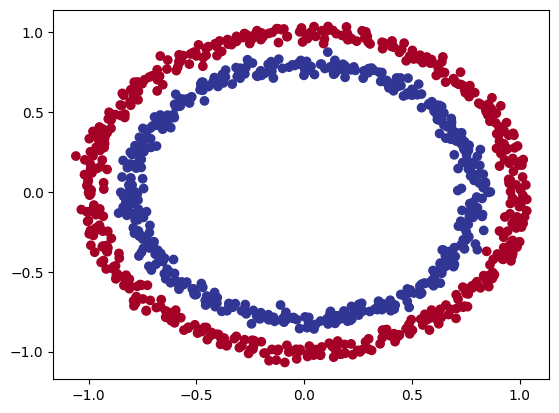

In [272]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

### 1.1 Input and output shapes

In [273]:
X.shape, y.shape

((1000, 2), (1000,))

In [274]:
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [275]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [276]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### 2. Building a model

In [277]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [278]:
# Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)


    def forward(self, x):

        return self.layer_2(self.layer_1(x))

# Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [279]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

### Setup loss function and optimizer

In [280]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [281]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

### 3. Train model

In [282]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0', grad_fn=<SliceBackward0>)

In [283]:
# Use sigmoid on model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [284]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

### Building a training and testing loop

In [285]:
torch.manual_seed(42)

epochs = 100


X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_0.train()

    # Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Calculate loss/accuracy

    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backwards
    loss.backward()

    # Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69796, Accuracy: 51.88% | Test loss: 0.69440, Test acc: 58.00%
Epoch: 10 | Loss: 0.69590, Accuracy: 51.25% | Test loss: 0.69305, Test acc: 53.00%
Epoch: 20 | Loss: 0.69490, Accuracy: 51.62% | Test loss: 0.69254, Test acc: 49.50%
Epoch: 30 | Loss: 0.69435, Accuracy: 51.12% | Test loss: 0.69236, Test acc: 49.50%
Epoch: 40 | Loss: 0.69401, Accuracy: 50.88% | Test loss: 0.69232, Test acc: 51.00%
Epoch: 50 | Loss: 0.69378, Accuracy: 50.25% | Test loss: 0.69234, Test acc: 50.00%
Epoch: 60 | Loss: 0.69362, Accuracy: 50.00% | Test loss: 0.69239, Test acc: 51.50%
Epoch: 70 | Loss: 0.69351, Accuracy: 50.25% | Test loss: 0.69246, Test acc: 51.00%
Epoch: 80 | Loss: 0.69342, Accuracy: 49.88% | Test loss: 0.69254, Test acc: 50.00%
Epoch: 90 | Loss: 0.69336, Accuracy: 49.88% | Test loss: 0.69262, Test acc: 53.00%


In [286]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


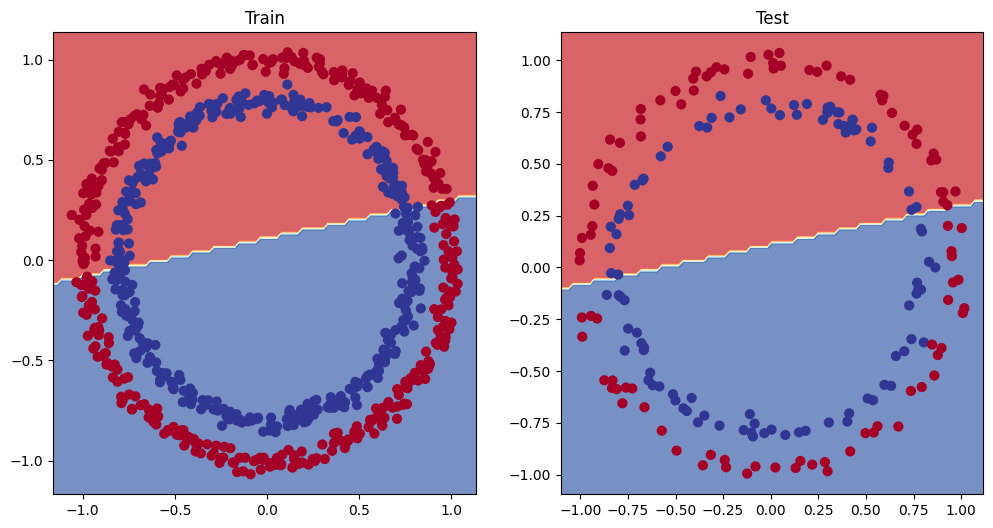

In [287]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### 6. non-linearity

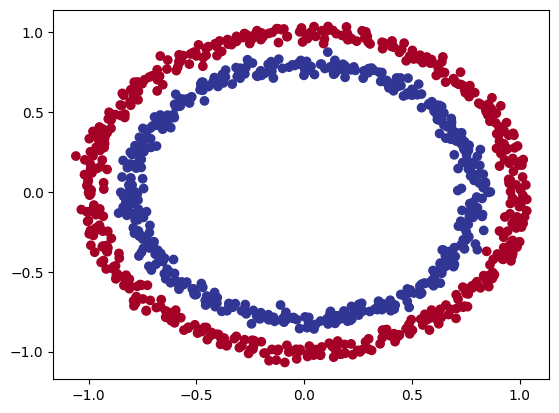

In [288]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);



In [289]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### Building a model with non-linearit

In [290]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    # Intersperse the ReLU activation function between layers
      return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [291]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

### Training a model with non-linearity

In [292]:

torch.manual_seed(42)
epochs = 2000
# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calculate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 200 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 1000 | Loss: 0.56818, Accuracy: 87.75% | Test Loss: 0.57378, Test Accuracy: 86.50%
Epoch: 1200 | Loss: 0.37056, Accuracy: 97.75% | Test Loss: 0.40595, Test Accuracy: 92.00%
Epoch: 1400 | Loss: 0.17180, Accuracy: 99.50% | Test Loss: 0.22108, Test Accuracy: 97.50%
Epoch: 1600 | Loss: 0.09123, Accuracy: 99.88% | Test Loss: 0.12741, Test Accuracy: 99.50%
Epoch: 1800 | Loss: 0.05773, Accuracy: 99.88% | Test Loss: 0.08672, Test Accuracy: 99.50%


### Evaluating a model trained with non-linear activation functions

In [293]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

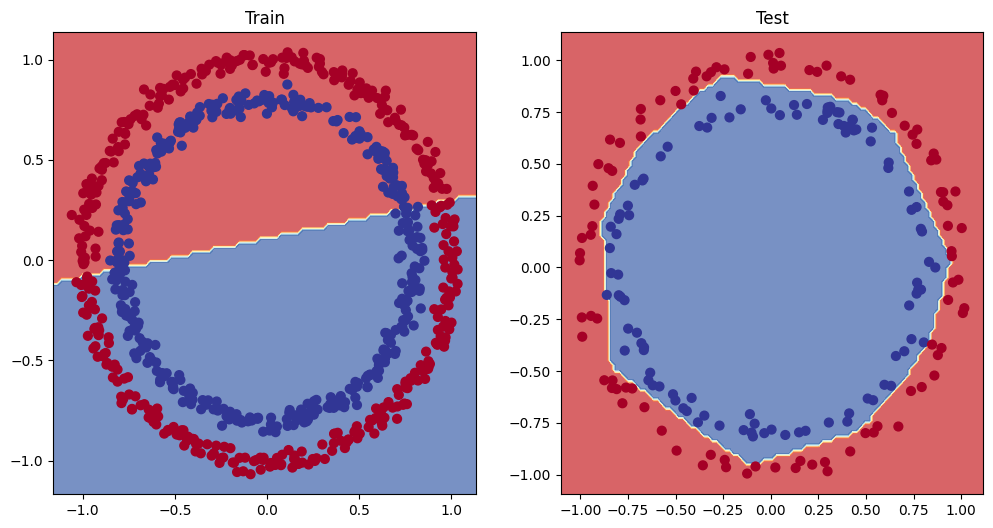

In [294]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

## 8. Putting things together by building a multi-class PyTorch model

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


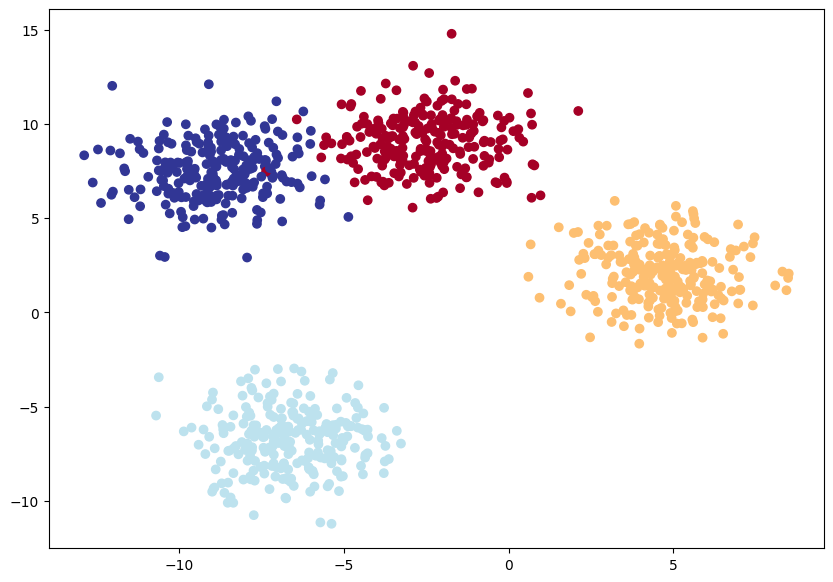

In [295]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

### Building a multi-class classification model in PyTorch

In [296]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)


model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [297]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.01)

###  Training and testing loop for a multi-class PyTorch model

In [298]:
# Fit the model
torch.manual_seed(42)


epochs = 1000


X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()


    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)


    optimizer.zero_grad()


    loss.backward()


    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():

      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)


    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.14724, Test Acc: 38.50%
Epoch: 100 | Loss: 0.64382, Acc: 96.88% | Test Loss: 0.68117, Test Acc: 97.00%
Epoch: 200 | Loss: 0.41891, Acc: 98.62% | Test Loss: 0.44228, Test Acc: 100.00%
Epoch: 300 | Loss: 0.23740, Acc: 99.25% | Test Loss: 0.24455, Test Acc: 99.50%
Epoch: 400 | Loss: 0.10433, Acc: 99.25% | Test Loss: 0.10148, Test Acc: 99.50%
Epoch: 500 | Loss: 0.06482, Acc: 99.25% | Test Loss: 0.05914, Test Acc: 99.50%
Epoch: 600 | Loss: 0.05031, Acc: 99.25% | Test Loss: 0.04355, Test Acc: 99.50%
Epoch: 700 | Loss: 0.04289, Acc: 99.25% | Test Loss: 0.03538, Test Acc: 99.50%
Epoch: 800 | Loss: 0.03833, Acc: 99.25% | Test Loss: 0.03022, Test Acc: 99.50%
Epoch: 900 | Loss: 0.03527, Acc: 99.25% | Test Loss: 0.02690, Test Acc: 99.50%


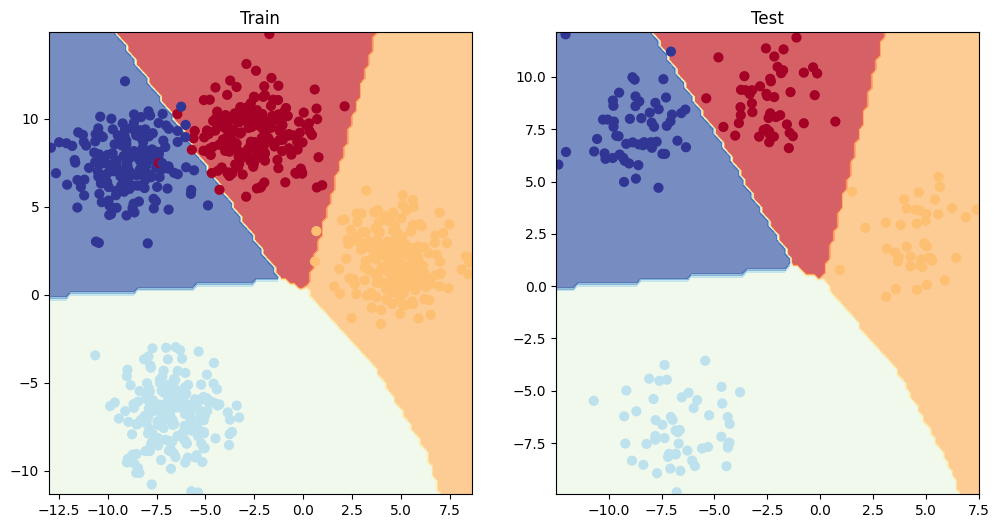

In [299]:
# Evaluating
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

# 02. PyTorch Classification Exercises

The following is a template for 02. PyTorch Classification exercises.

It's only starter code and it's your job to fill in the blanks.

Because of the flexibility of PyTorch, there may be more than one way to answer the question.

Don't worry about trying to be *right* just try writing code that suffices the question.

## Resources
* These exercises are based on [notebook 02 of the learn PyTorch course](https://www.learnpytorch.io/02_pytorch_classification/).
* You can see one form of [solutions on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions) (but try the exercises below yourself first!).

In [300]:
# Import torch
import torch

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Setup random seed
RANDOM_SEED = 42

## 1. Make a binary classification dataset with Scikit-Learn's [`make_moons()`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.
  * For consistency, the dataset should have 1000 samples and a `random_state=42`.
  * Turn the data into PyTorch tensors.
  * Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

In [301]:
# Create a dataset with Scikit-Learn's make_moons()
from sklearn.datasets import make_moons
n_samples = 1000
X, y = make_moons(n_samples,
                  noise=0.07,
                  random_state=RANDOM_SEED)

print(X[:5])
print(y[:5])

[[-0.03341062  0.4213911 ]
 [ 0.99882703 -0.4428903 ]
 [ 0.88959204 -0.32784256]
 [ 0.34195829 -0.41768975]
 [-0.83853099  0.53237483]]
[1 1 1 1 0]


In [302]:
# Turn data into a DataFrame
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,-0.033411,0.421391,1
1,0.998827,-0.442890,1
2,0.889592,-0.327843,1
3,0.341958,-0.417690,1
4,-0.838531,0.532375,0
5,0.599064,-0.289773,1
6,0.290090,-0.204688,1
7,-0.038269,0.459429,1
8,1.613771,-0.293970,1
9,0.693337,0.827819,0


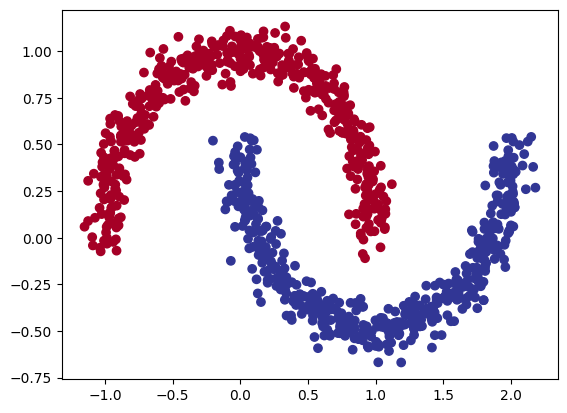

In [303]:
# Visualize the data on a scatter plot
import matplotlib.pyplot as plt
#plt.figure(figsize=(10, 7))
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [304]:
# Turn data into tensors of dtype float
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)


# Split the data into train and test sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)
X[:5], y[:5]
#X_train[:5], y_train[:5]

(tensor([[-0.0334,  0.4214],
         [ 0.9988, -0.4429],
         [ 0.8896, -0.3278],
         [ 0.3420, -0.4177],
         [-0.8385,  0.5324]]),
 tensor([1., 1., 1., 1., 0.]))

## 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
  * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.
  

In [305]:
import torch
from torch import nn

# Inherit from nn.Module to make a model capable of fitting the mooon data
class MoonModelV0(nn.Module):
    ## Your code here ##
    def __init__(self, input_features, output_features, hidden_units=8):
      super().__init__()
      self.linear_layer_stack = nn.Sequential(
          nn.Linear(in_features=input_features, out_features=hidden_units),
          nn.ReLU(),
          nn.Linear(in_features=hidden_units, out_features=hidden_units),
          nn.ReLU(),
          nn.Linear(in_features=hidden_units, out_features=output_features),
      )

    def forward(self, x):
        ## Your code here ##
        return self.linear_layer_stack(x)

# Instantiate the model
## Your code here ##
model_0 = MoonModelV0(2, 1).to(device)
model_0

MoonModelV0(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model built in 2.

In [306]:
# Setup loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup optimizer to optimize model's parameters
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
  * Do a forward pass of the model to see what's coming out in the form of logits, prediction probabilities and labels.
  * To measure model accuray, you can create your own accuracy function or use the accuracy function in [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/).
  * Train the model for long enough for it to reach over 96% accuracy.
  * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [307]:
# What's coming out of our model?
y_logits = model_0(X_test.to(device))[:5]
# logits (raw outputs of model)
print(f"Logits: {y_logits}")

## Your code here ##
y_pred_probs = torch.sigmoid(y_logits)
# Prediction probabilities
print(f"Pred probs: {y_pred_probs}")

## Your code here ##
y_pred_labels = torch.round(y_pred_probs)
# Prediction labels
print(f"Pred labels: {y_pred_labels}")
## Your code here ##

Logits: tensor([[-0.0978],
        [-0.2175],
        [-0.1927],
        [-0.1942],
        [-0.3049]], device='cuda:0', grad_fn=<SliceBackward0>)
Pred probs: tensor([[0.4756],
        [0.4458],
        [0.4520],
        [0.4516],
        [0.4244]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Pred labels: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<RoundBackward0>)


In [308]:
# Let's calculuate the accuracy using accuracy from TorchMetrics
!pip -q install torchmetrics # Colab doesn't come with torchmetrics
from torchmetrics import Accuracy

## TODO: Uncomment this code to use the Accuracy function
acc_fn = Accuracy(task="multiclass", num_classes=2).to(device) # send accuracy function to device
acc_fn

MulticlassAccuracy()

In [309]:

torch.manual_seed(RANDOM_SEED)

# Setup epochs
epochs = 1000

# Send data to the device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through the data
for epoch in range(epochs):
  ### Training
  model_0.train()


  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  # Turn logits into prediction probabilities
  y_pred_probs = torch.sigmoid(y_logits)

  # Turn prediction probabilities into prediction labels
  y_pred = torch.round(y_pred_probs)

  # 2. Calculaute the loss
  loss = loss_fn(y_logits, y_train)

  # Calculate the accuracy
  acc = acc_fn(y_pred, y_train.int())

  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Step the optimizer
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass (to get the logits)
    test_logits = model_0(X_test).squeeze()

    test_pred_probs = torch.sigmoid(test_logits)
    # Turn the test logits into prediction labels
    test_pred = torch.round(test_pred_probs)

    # 2. Caculate the test loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = acc_fn(test_pred,
                      y_test.int())


  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")


Epoch: 0 | Loss: 0.71201, Acc: 0.50 | Test Loss: 0.70540, Test Acc: 0.50
Epoch: 100 | Loss: 0.36405, Acc: 0.84 | Test Loss: 0.37636, Test Acc: 0.83
Epoch: 200 | Loss: 0.24491, Acc: 0.88 | Test Loss: 0.24282, Test Acc: 0.90
Epoch: 300 | Loss: 0.22631, Acc: 0.89 | Test Loss: 0.21916, Test Acc: 0.90
Epoch: 400 | Loss: 0.20836, Acc: 0.90 | Test Loss: 0.19934, Test Acc: 0.92
Epoch: 500 | Loss: 0.18014, Acc: 0.92 | Test Loss: 0.17002, Test Acc: 0.94
Epoch: 600 | Loss: 0.14001, Acc: 0.94 | Test Loss: 0.12976, Test Acc: 0.95
Epoch: 700 | Loss: 0.09700, Acc: 0.97 | Test Loss: 0.08738, Test Acc: 0.98
Epoch: 800 | Loss: 0.06427, Acc: 0.99 | Test Loss: 0.05613, Test Acc: 1.00
Epoch: 900 | Loss: 0.04411, Acc: 0.99 | Test Loss: 0.03717, Test Acc: 1.00


## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [310]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

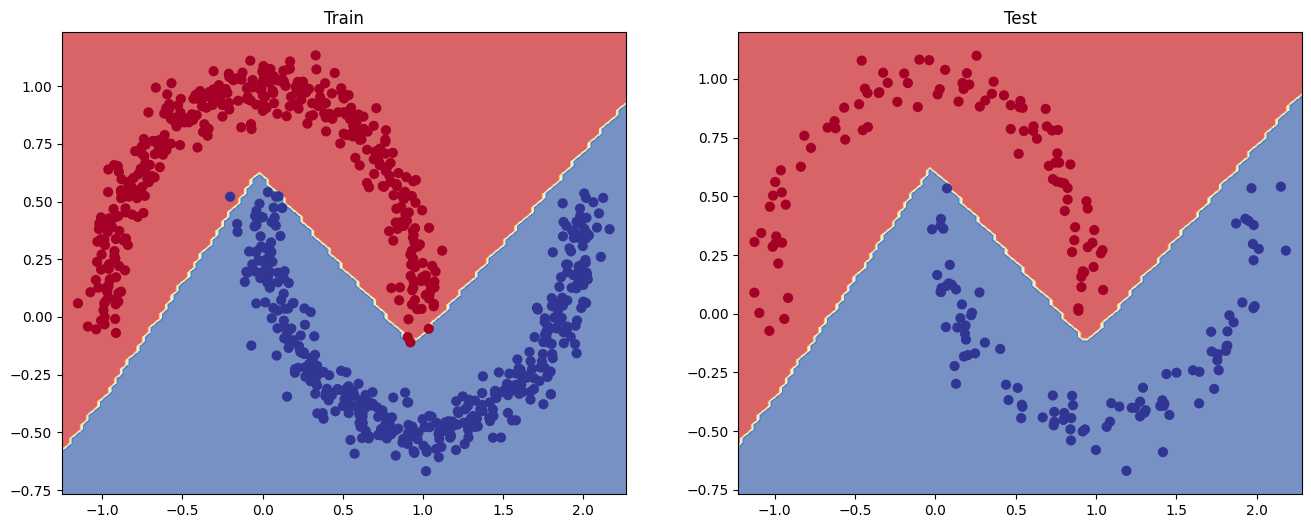

In [311]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
  * Feel free to reference the [ML cheatsheet website](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh) for the formula.

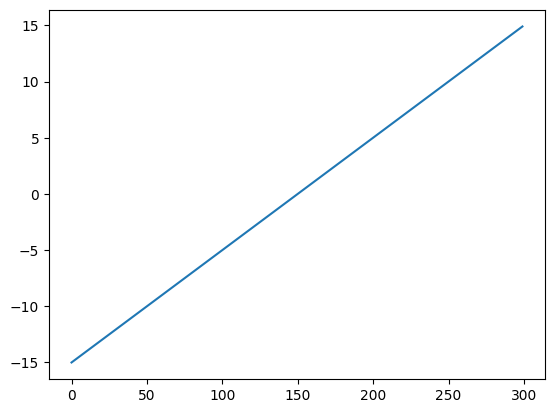

In [312]:
# Create a straight line tensor
tensor_line = torch.arange(-15, 15, 0.1)
plt.plot(tensor_line)

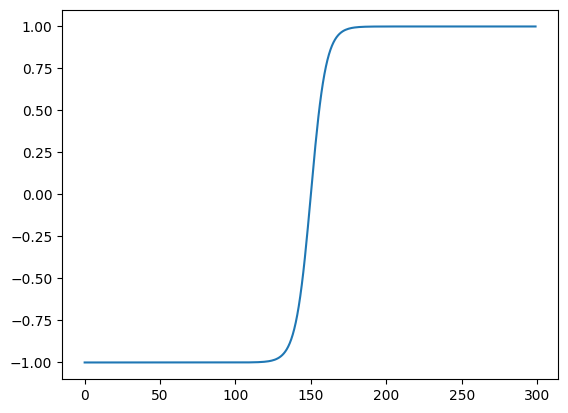

In [313]:
# Test torch.tanh() on the tensor and plot it
tensor_tanh = torch.tanh(tensor_line)
plt.plot(tensor_tanh)

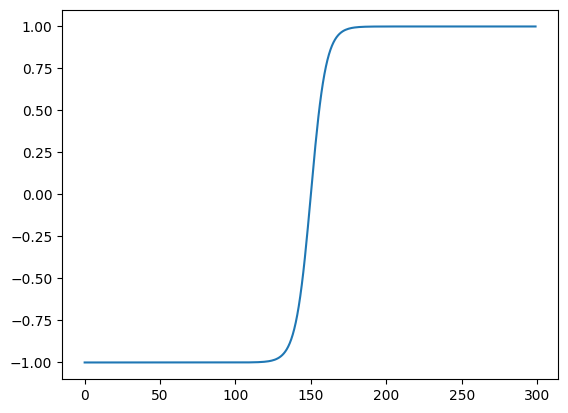

In [314]:
# Replicate torch.tanh() and plot it
def tenh(a):
  return ((torch.exp(a) - torch.exp(-a))/(torch.exp(a) + torch.exp(-a)))
plt.plot(tenh(tensor_line))

## 7. Create a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/) (see below for the code).
  * Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
  * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
  * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
  * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like) - 1000 epochs should be plenty.
  * Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

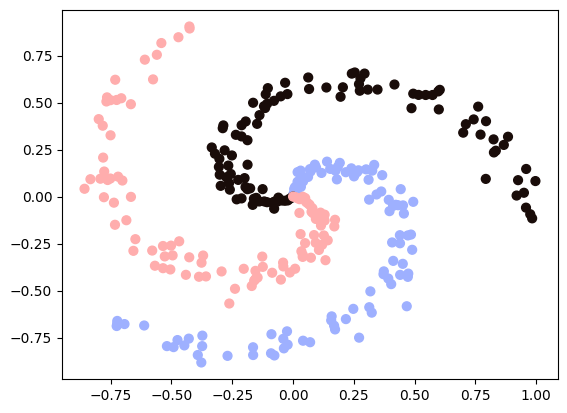

In [326]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.berlin)
plt.show()

In [327]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

In [317]:
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy
acc_fn = Accuracy(task="multiclass", num_classes=4).to(device)
acc_fn

MulticlassAccuracy()

In [337]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model by subclassing nn.Module
class SpiralModel(nn.Module):
    ## Your code here ##
    def __init__(self, input_features, output_features, hidden_units=6):
      super().__init__()
      self.linear_layer_stack = nn.Sequential(
          nn.Linear(in_features=input_features, out_features=hidden_units),
          nn.ReLU(),
          nn.Linear(in_features=hidden_units, out_features=hidden_units),
          nn.ReLU(),
          nn.Linear(in_features=hidden_units, out_features=hidden_units),
          nn.ReLU(),
          nn.Linear(in_features=hidden_units, out_features=output_features),
      )

    def forward(self, x):
        ## Your code here ##
        return self.linear_layer_stack(x)


# Instantiate model and send it to device
model_1 = SpiralModel(2, 3).to(device)
model_1


SpiralModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=6, bias=True)
    (3): ReLU()
    (4): Linear(in_features=6, out_features=6, bias=True)
    (5): ReLU()
    (6): Linear(in_features=6, out_features=3, bias=True)
  )
)

In [338]:
# What's coming out of our model?
y_logits = model_1(X_test.to(device))[:5]
# logits (raw outputs of model)
print(f"Logits: {y_logits}")

## Your code here ##
y_pred_probs = torch.sigmoid(y_logits)
# Prediction probabilities
print(f"Pred probs: {y_pred_probs}")

## Your code here ##
y_pred_labels = torch.round(y_pred_probs)
# Prediction labels
print(f"Pred labels: {y_pred_labels}")
## Your code here ##

Logits: tensor([[-0.0307, -0.3348, -0.1645],
        [-0.0301, -0.3270, -0.1585],
        [-0.0327, -0.3385, -0.1669],
        [-0.0310, -0.3362, -0.1655],
        [-0.0272, -0.3255, -0.1580]], device='cuda:0',
       grad_fn=<SliceBackward0>)
Pred probs: tensor([[0.4923, 0.4171, 0.4590],
        [0.4925, 0.4190, 0.4605],
        [0.4918, 0.4162, 0.4584],
        [0.4922, 0.4167, 0.4587],
        [0.4932, 0.4193, 0.4606]], device='cuda:0', grad_fn=<SigmoidBackward0>)
Pred labels: tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], device='cuda:0', grad_fn=<RoundBackward0>)


In [339]:
# Setup loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.2)

In [340]:
# Build a training loop for the model
torch.manual_seed(RANDOM_SEED)

# Set the number of epochs
epochs = 3000

X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)


# Loop over data
for epoch in range(epochs):
  model_1.train()

  ## Training

  # 1. Forward pass
  y_logits = model_1(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ## Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Caculate loss and acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

  if epoch % 150 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f} | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}")

Epoch: 0 | Loss: 1.11172, Acc: 32.50 | Test Loss: 1.09282, Test Acc: 36.67
Epoch: 150 | Loss: 1.08868, Acc: 35.00 | Test Loss: 1.09942, Test Acc: 26.67
Epoch: 300 | Loss: 0.89482, Acc: 45.83 | Test Loss: 0.88739, Test Acc: 48.33
Epoch: 450 | Loss: 0.75159, Acc: 60.00 | Test Loss: 0.76077, Test Acc: 51.67
Epoch: 600 | Loss: 0.54330, Acc: 80.42 | Test Loss: 0.57531, Test Acc: 70.00
Epoch: 750 | Loss: 0.43678, Acc: 82.08 | Test Loss: 0.44946, Test Acc: 68.33
Epoch: 900 | Loss: 0.25936, Acc: 90.83 | Test Loss: 0.21616, Test Acc: 93.33
Epoch: 1050 | Loss: 0.11619, Acc: 95.42 | Test Loss: 0.07472, Test Acc: 98.33
Epoch: 1200 | Loss: 0.07964, Acc: 96.67 | Test Loss: 0.04556, Test Acc: 98.33
Epoch: 1350 | Loss: 0.06386, Acc: 97.08 | Test Loss: 0.03346, Test Acc: 98.33
Epoch: 1500 | Loss: 0.05478, Acc: 97.50 | Test Loss: 0.02725, Test Acc: 98.33
Epoch: 1650 | Loss: 0.04860, Acc: 97.50 | Test Loss: 0.02292, Test Acc: 98.33
Epoch: 1800 | Loss: 0.04406, Acc: 97.92 | Test Loss: 0.01961, Test Acc: 1

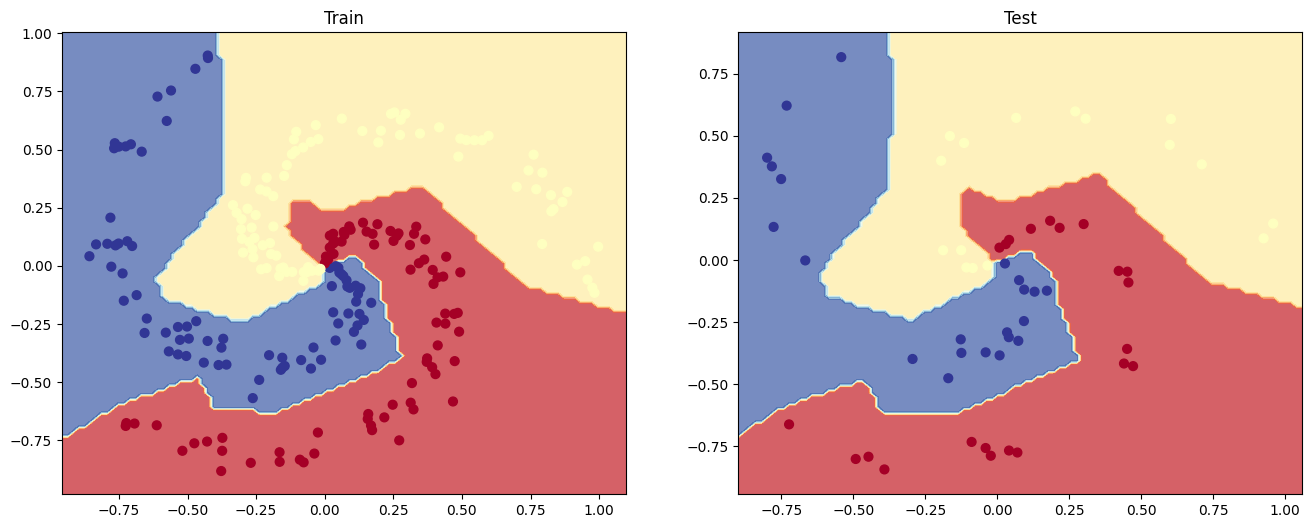

In [341]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)